In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image
import pathlib
import splitfolders
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
import torchvision

import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
# from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import itertools

In [16]:
# New dataset path
data_dir = r'C:\Users\Evans.Siaw\Evans.Siaw\evans\evans\pytorchProjects\trainValSet'
data_dir = pathlib.Path(data_dir)

In [17]:
os.listdir(r'C:\Users\Evans.Siaw\Evans.Siaw\evans\evans\pytorchProjects\trainValSet')

['train', 'val']

In [18]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [19]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [20]:
# import and load train, validation
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)


In [21]:
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([32, 3, 256, 256])
Shape of y: torch.Size([32]) torch.int64

Validation data:
Shape of X : torch.Size([32, 3, 256, 256])
Shape of y: torch.Size([32]) torch.int64



In [22]:
def findConv2dOutShape(hin,win,conv,pool=2):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

In [23]:
class BrainScanPlaneDetector(nn.Module):
    def __init__(self, num_classes = 2):
        super(BrainScanPlaneDetector, self).__init__()
        
        # Convolutional layers
        self.conv0 = nn.Conv2d(3, 64, kernel_size = 3)
        h,w = findConv2dOutShape(256,256,self.conv0)
        self.conv1 = nn.Conv2d(64, 128, kernel_size = 3)
        h,w = findConv2dOutShape(h,w,self.conv1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size = 3)
        h,w = findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(256, 512, kernel_size = 3)
        h,w = findConv2dOutShape(h,w,self.conv3)
            
            
        #Max pooling layers
        self.maxPool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        #Fully connected layers
        self.num_flatten=h*w*512
        self.fc1 = nn.Linear(self.num_flatten,512 )
        self.fc2 = nn.Linear(512, num_classes)
        
        #Activation functions
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self,x): 
        # Convolutional layers with ReLU activation and max pooling
        x = self.maxPool(self.relu(self.conv0(x)))
        x = self.maxPool(self.relu(self.conv1(x)))
        x = self.maxPool(self.relu(self.conv2(x)))
        x = self.maxPool(self.relu(self.conv3(x)))
        
        # Flatten the output of the convolutional layers
        x = x.view(-1, self.num_flatten)
        
        # Fully connected layers with dropout
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [29]:
# Create an instance of the BrainScanPlaneDetector model
model = BrainScanPlaneDetector()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = model.to(device)
    

In [31]:
# torch.cuda.is_available()

True

In [30]:
# Model Summary for CNN Model
summary(cnn_model, input_size=(3,256, 256),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 254, 254]           1,792
              ReLU-2         [-1, 64, 254, 254]               0
         MaxPool2d-3         [-1, 64, 127, 127]               0
            Conv2d-4        [-1, 128, 125, 125]          73,856
              ReLU-5        [-1, 128, 125, 125]               0
         MaxPool2d-6          [-1, 128, 62, 62]               0
            Conv2d-7          [-1, 256, 60, 60]         295,168
              ReLU-8          [-1, 256, 60, 60]               0
         MaxPool2d-9          [-1, 256, 30, 30]               0
           Conv2d-10          [-1, 512, 28, 28]       1,180,160
             ReLU-11          [-1, 512, 28, 28]               0
        MaxPool2d-12          [-1, 512, 14, 14]               0
           Linear-13                  [-1, 512]      51,380,736
             ReLU-14                  [

In [32]:
###Defining loss function
loss_func = nn.CrossEntropyLoss()

In [33]:
##Optimizer
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [34]:
def train_and_evaluate_model(model, train_loader, valid_loader, loss_funtion, optimizer, num_epochs, save_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
      # initialize best loss to a large value
    best_valid_loss = float('inf')
    
      # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    accuracy_history={"train": [],"val": []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_funtion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
        
        train_accuracy = 100 * correct_train / total_train
        train_loss /= len(train_loader)
        
         # collect loss and accuracy for training
        loss_history["train"].append(train_loss)
        accuracy_history["train"].append(train_accuracy)
        
        # Validation phase
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = loss_funtion(outputs, labels)
                
                valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_valid += (predicted == labels).sum().item()
                total_valid += labels.size(0)
        
        valid_accuracy = 100 * correct_valid / total_valid
        valid_loss /=  len(valid_loader)
        
         # collect loss and accuracy for validation 
        loss_history["val"].append(valid_loss)
        accuracy_history["val"].append(valid_accuracy)
        
        # Save the model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
            model.load_state_dict(torch.load(save_path))
        # Print training and validation statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')
    model.load_state_dict(torch.load(save_path))
    return model, loss_history, accuracy_history

In [ ]:
num_epochs = 2
save_path='model.pth'
cnn_model, loss_hist,accuracy_hist = train_and_evaluate_model(model, train_loader,val_loader, loss_func, optimizer, 10, save_path)

In [96]:

data = {
    "loss_hist['train']": loss_hist["train"],
    "loss_hist['val']": loss_hist["val"],
    "accuracy_hist['train']": accuracy_hist["train"],
    "accuracy_hist['val']": accuracy_hist["val"]
}

df = pd.DataFrame(data)
df.to_csv("modelResult.csv")

In [103]:
print(cnn_model)


<All keys matched successfully>


<AxesSubplot:>

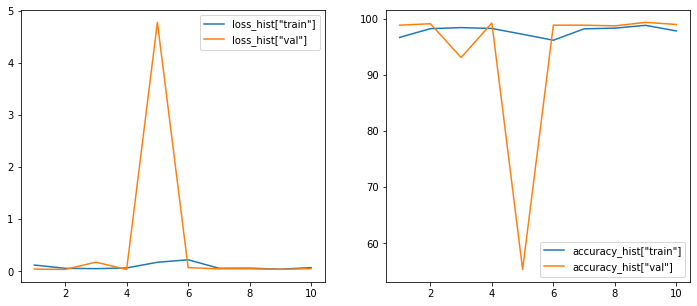

In [100]:
# Convergence History Plot

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,num_epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,num_epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,num_epochs+1)],y=accuracy_hist["train"],ax=ax[1],label='accuracy_hist["train"]')
sns.lineplot(x=[*range(1,num_epochs+1)],y=accuracy_hist["val"],ax=ax[1],label='accuracy_hist["val"]')

In [98]:
# define function For Classification Report
def True_and_Pred(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred


# check confusion matrix for error analysis
y_true, y_pred = True_and_Pred(val_loader, cnn_model)

print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

TypeError: '_IncompatibleKeys' object is not callable

In [ ]:
CLA_label = {
    0 : 'Axial',
    1 : 'Sagital'
}

# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)